# PROYECTO MACHINE LEARNING PARA TEXTOS

## Modelos de Clasificación de reseñas de películas en IMDB

# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

Primero procedemos a importar Librerías:

In [33]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import sklearn.metrics as metrics

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

Leemos el Conjunto de Datos:

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Imprimimos la información general/resumida del conjunto de datos.
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## Preparación de los datos

In [6]:
# Vista de los primeros registros
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
# Verificamos que no hay filas totalmente duplicadas: 
print('El número de filas totalmente duplicadas en el Conjunto de datos es:', df_reviews.duplicated().sum())

El número de filas totalmente duplicadas en el Conjunto de datos es: 0


In [8]:
#Verificamos que no hay valores ausentes en ninguno de los Dataframes.
print("Valores ausentes Conjuto de Datos", df_reviews.isna().sum())

Valores ausentes Conjuto de Datos tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [9]:
# Imputamos los valores ausentes con cero
df_reviews['average_rating'].fillna(0, inplace=True)
df_reviews['votes'].fillna(0, inplace=True)

# Convertimos la columna 'votes' a enteros
df_reviews['votes'] = df_reviews['votes'].astype(int)

# Verificamos que ya no hay valores ausentes
print("Valores ausentes después de la imputación:")
print(df_reviews.isna().sum())

Valores ausentes después de la imputación:
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [10]:
# Revisamos las estadísticas descriptivas de los datos.
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47331.000000,4.733100e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998025,2.556184e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494766,8.366844e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.260000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


En función de los resultados del método describe(), podemos indicar los siguientes comentarios sobre las variables:

- start_year

mean (promedio): El promedio del año de inicio es aproximadamente 1989. Esto sugiere que la mayoría de las películas en el conjunto de datos son de finales del siglo XX.

std (desviación estándar): La desviación estándar de aproximadamente 19.6 indica una dispersión moderada alrededor del promedio.

min (mínimo) y max (máximo): Las películas en el conjunto de datos van desde el año 1894 hasta 2010.

- is_adult

mean (promedio): El valor promedio cercano a 0 indica que la mayoría de las películas no son para adultos.

std (desviación estándar): La baja desviación estándar refuerza que casi todas las películas no son para adultos.

min (mínimo) y max (máximo): Esto confirma que is_adult es una variable binaria (0 o 1).

- average_rating

mean (promedio): El promedio de calificación es aproximadamente 6, lo que indica una calificación media favorable para la mayoría de las películas.

std (desviación estándar): La desviación estándar de aproximadamente 1.49 muestra una variabilidad considerable en las calificaciones.

min (mínimo) y max (máximo): Las calificaciones van desde 1.4 hasta 9.7, lo que indica una amplia gama de opiniones.

- votes

mean (promedio): El promedio de votos es aproximadamente 25,563. Esto sugiere que las películas en el conjunto de datos han recibido una cantidad significativa de votos.

std (desviación estándar): La desviación estándar alta de 83,670 indica que hay algunas películas con un número de votos extremadamente alto.

min (mínimo) y max (máximo): Los votos van desde 9 hasta 1,739,448, lo que muestra una gran disparidad en la popularidad de las películas.

- rating

mean (promedio): El promedio de calificación es aproximadamente 5.48.

std (desviación estándar): La desviación estándar de 3.47 muestra una variabilidad considerable en las calificaciones.

min (mínimo) y max (máximo): Las calificaciones varían desde 1 hasta 10.

- pos

mean (promedio): El valor promedio cercano a 0.499 indica que el conjunto de datos está balanceado con respecto a las críticas positivas (1) y negativas (0).

std (desviación estándar): La desviación estándar de 0.50 confirma que las críticas están distribuidas casi uniformemente.

min (mínimo) y max (máximo): Esto confirma que pos es una variable binaria (0 o 1).



## EDA

Filtrar columnas relevantes y mostrar un resumen

In [11]:
# Filtramos las columnas relevantes
df_reviews_r = df_reviews[['review', 'pos', 'ds_part']]

# Verificamos los primeros registros
df_reviews_r.head()

,review,pos,ds_part
0,The pakage implies that Warren Beatty and Gold...,0,train
1,How the hell did they get this made?! Presenti...,0,train
2,There is no real story the film seems more lik...,0,test
3,Um .... a serious film about troubled teens in...,1,test
4,I'm totally agree with GarryJohal from Singapo...,1,test


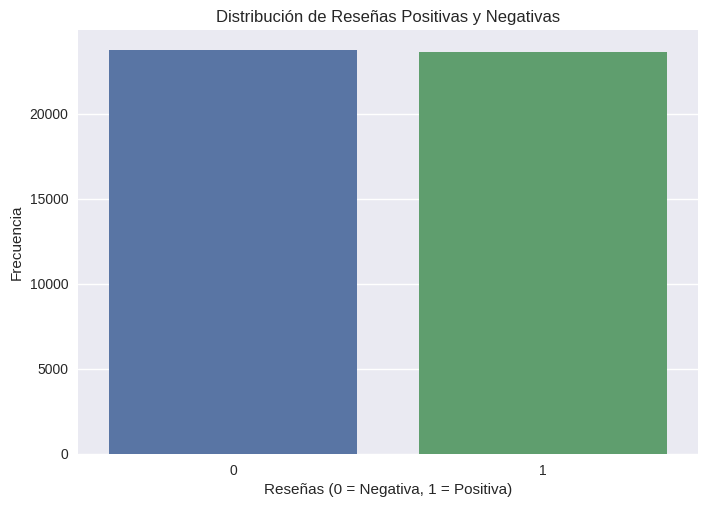

Porcentaje de reseñas positivas: 49.90%
Porcentaje de reseñas negativas: 50.10%


In [12]:
# Analizamos el desequilibrio de clases
sns.countplot(x='pos', data=df_reviews_r)
plt.title('Distribución de Reseñas Positivas y Negativas')
plt.xlabel('Reseñas (0 = Negativa, 1 = Positiva)')
plt.ylabel('Frecuencia')
plt.show()

# Mostramos la distribución en porcentaje
positive_percentage = df_reviews_r['pos'].mean() * 100
negative_percentage = 100 - positive_percentage
print(f"Porcentaje de reseñas positivas: {positive_percentage:.2f}%")
print(f"Porcentaje de reseñas negativas: {negative_percentage:.2f}%")

La gráfica muestra que las clases están bastante equilibradas, con un 49.90% de reseñas positivas y un 50.10% de reseñas negativas. Este equilibrio es favorable para el entrenamiento del modelo, ya que no tenemos que lidiar con un desequilibrio de clases significativo.

Veamos el número de películas y reseñas a lo largo de los años.

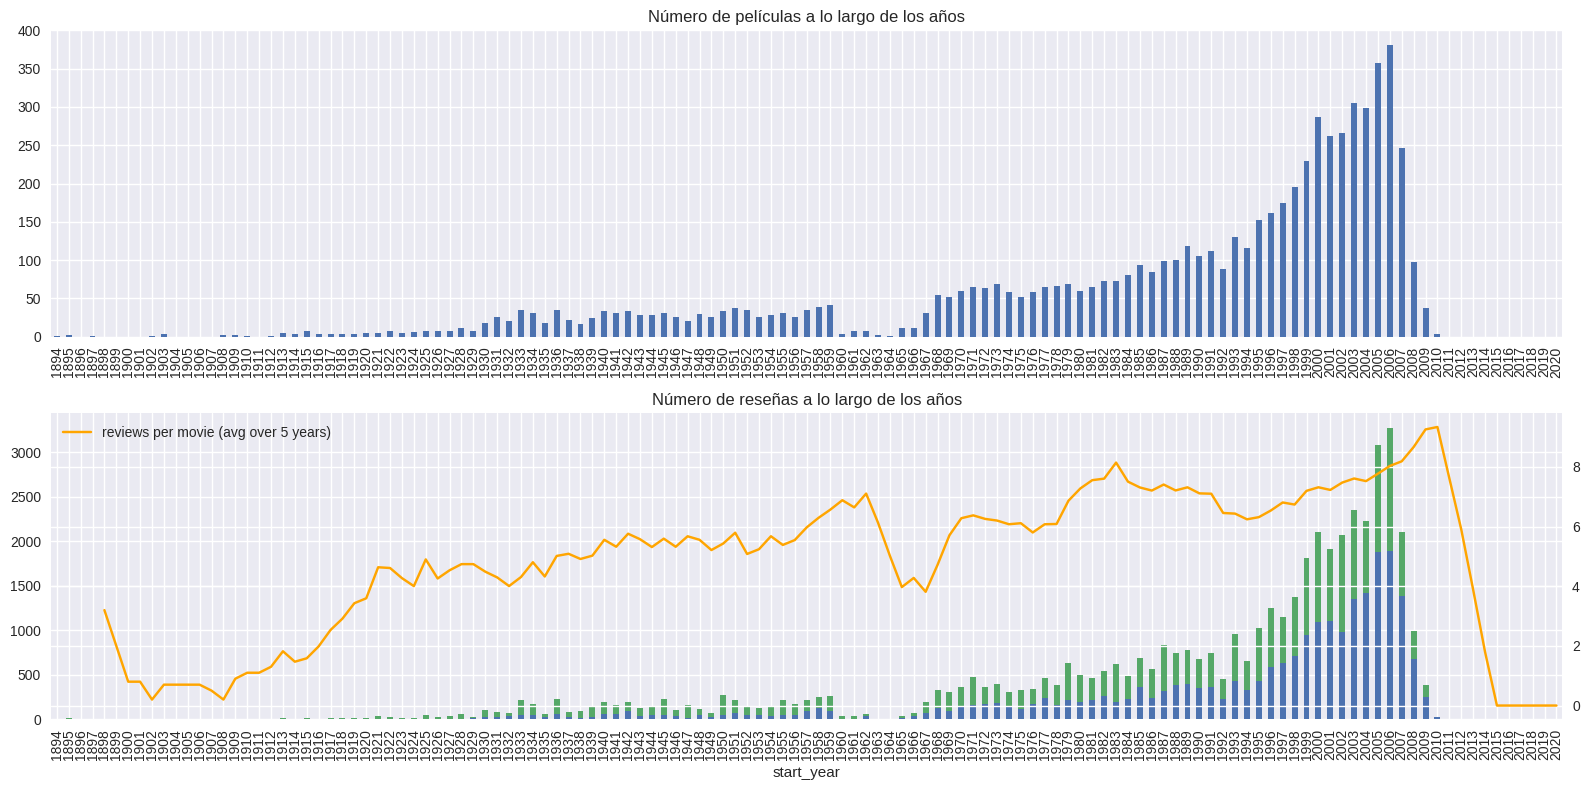

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

- Gráfico 1: Número de películas a lo largo de los años

Observación general: Se observa un aumento constante en el número de películas producidas a lo largo del tiempo, especialmente a partir de la década de 1980.

Incremento notable: Desde los años 2000, hay un aumento significativo en la producción de películas, alcanzando su punto máximo alrededor del año 2008.

Descenso reciente: Hay un aparente descenso en el número de películas en los años más recientes, lo cual puede deberse a que los datos están incompletos para esos años o a un cambio en la base de datos.

- Gráfico 2: Número de reseñas a lo largo de los años

Reseñas por año: Similar al gráfico anterior, el número de reseñas también ha aumentado con el tiempo, con un incremento considerable a partir de la década de 1980.

Reseñas positivas vs negativas: La gráfica de barras apiladas muestra que tanto las reseñas positivas como las negativas han aumentado con el tiempo. No parece haber un sesgo significativo hacia un tipo de reseña en particular.

Media móvil de reseñas por película: La línea naranja indica el número promedio de reseñas por película en un período de cinco años. Este promedio ha fluctuado a lo largo del tiempo, alcanzando picos alrededor de 1990 y 2005.


Conclusiones
Tanto la producción de películas como el número de reseñas han aumentado significativamente desde la década de 1980, con un pico alrededor del año 2008.

La distribución de reseñas positivas y negativas parece estar equilibrada, lo cual es favorable para el análisis de sentimientos y el entrenamiento de modelos.


Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

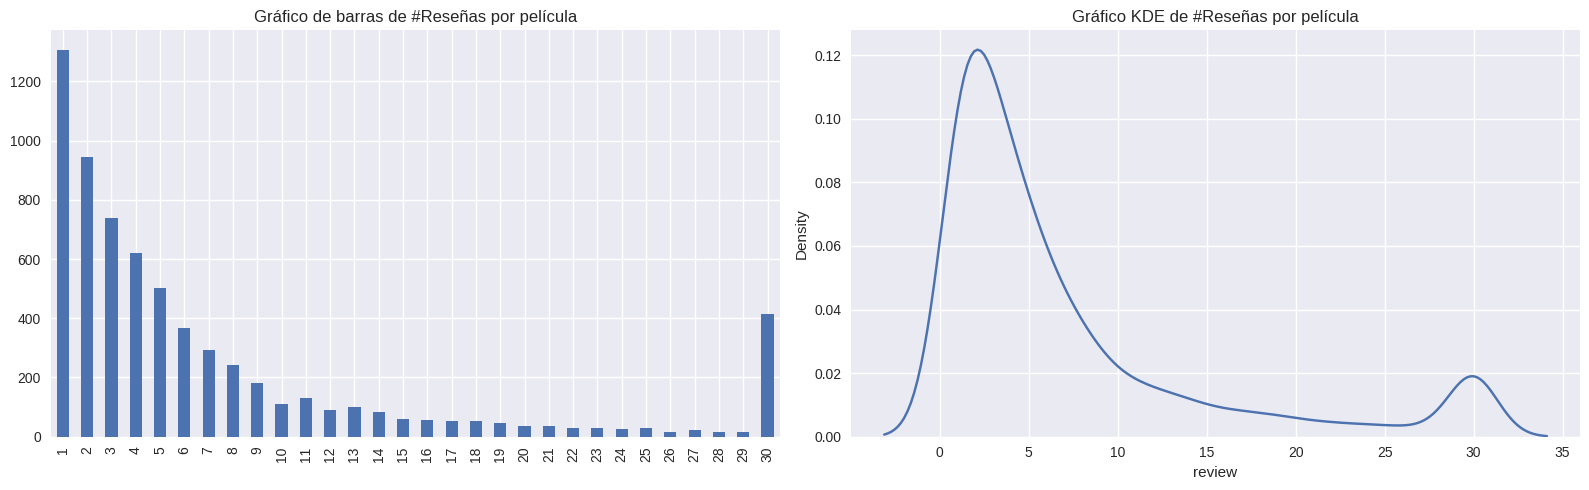

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

- Gráfico de barras de número de reseñas por película

La mayoría de las películas tienen un pequeño número de reseñas. La distribución es altamente sesgada hacia la izquierda, indicando que la mayoría de las películas tienen pocas reseñas.
Hay una gran cantidad de películas con solo una reseña, lo que podría indicar que hay muchas películas menos conocidas o menos populares en el conjunto de datos.


- Gráfico KDE de número de reseñas por película

El gráfico KDE muestra una distribución suavizada de las reseñas por película. La mayoría de las películas tienen entre 1 y 5 reseñas.
La curva tiene un principal valor alrededor de 2 reseñas y un valor menor alrededor de 30 reseñas. Esto coincide con lo observado en el gráfico de barras.

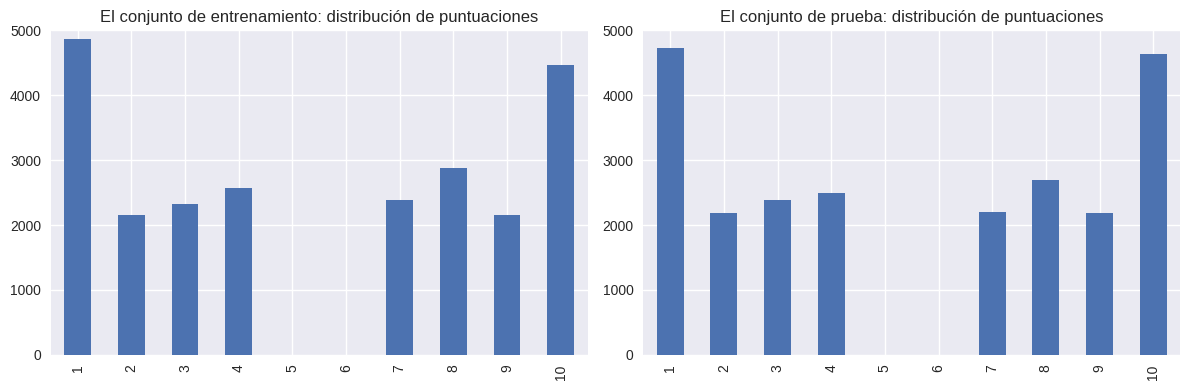

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

- Gráfico 1: El conjunto de entrenamiento: distribución de puntuaciones

Hay un número significativamente mayor de reseñas con puntuaciones de 1 y 10 en comparación con otras puntuaciones. Esto podría indicar que los usuarios tienden a dar puntuaciones extremas con mayor frecuencia.

Aparte de los valores altos en las puntuaciones extremas, las puntuaciones intermedias (2-9) están relativamente bien distribuidas, aunque con menor frecuencia.

- Gráfico 2: El conjunto de prueba: 
La distribución de puntuaciones en el conjunto de prueba es muy similar a la del conjunto de entrenamiento, lo cual es positivo ya que indica que ambos conjuntos son comparables.

Al igual que en el conjunto de entrenamiento, hay un número significativamente mayor en las puntuaciones de 1 y 10.
Las puntuaciones intermedias están también bien distribuidas, lo que sugiere una buena representación de las diferentes puntuaciones en el conjunto de prueba.


La similitud en la distribución de puntuaciones entre el conjunto de entrenamiento y el de prueba es crucial para garantizar que el modelo entrenado tenga un buen rendimiento en datos no vistos.

Los valores altos en las puntuaciones extremas pueden indicar una tendencia de los usuarios a dar opiniones polarizadas sobre las películas. Esto puede tener implicaciones en el análisis de sentimientos y el entrenamiento del modelo, ya que las puntuaciones extremas pueden tener un mayor peso en la clasificación de reseñas.

La distribución relativamente uniforme de las puntuaciones intermedias sugiere que el conjunto de datos cubre una gama amplia de opiniones, lo que es beneficioso para entrenar un modelo robusto.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


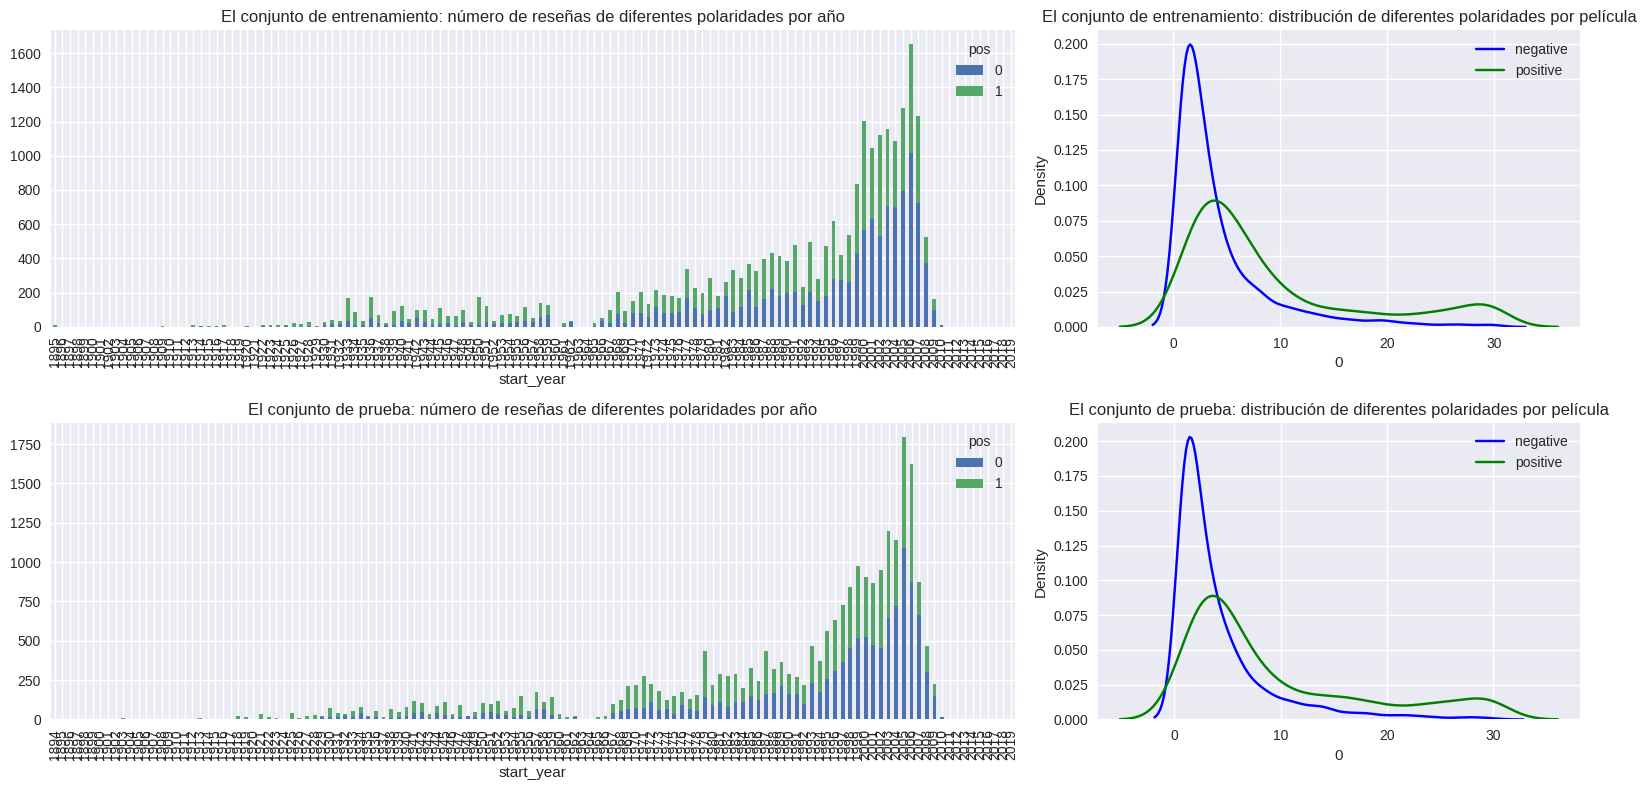

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

- Gráfico 1: El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año

Se observa un aumento en el número de reseñas tanto positivas como negativas a lo largo de los años, especialmente a partir de los años 2000.
Desde el año 2000 en adelante, hay un aumento notable en el número de reseñas, con un alto valor alrededor de 2008.
Las reseñas positivas y negativas están bastante equilibradas a lo largo de los años, lo cual es beneficioso para el entrenamiento del modelo.

- Gráfico 2: El conjunto de entrenamiento: distribución de diferentes polaridades por película

Densidad de reseñas negativas: La curva de densidad muestra que la mayoría de las películas tienen pocas reseñas negativas, con una densidad máxima alrededor de 1 reseña.
Densidad de reseñas positivas: La curva de densidad de las reseñas positivas tiene un pico similar, pero es ligeramente menor que la de las reseñas negativas.
Cola larga: Ambas distribuciones muestran colas largas, indicando que hay algunas películas con un número significativo de reseñas tanto positivas como negativas.

- Gráfico 3: El conjunto de prueba: número de reseñas de diferentes polaridades por año

Similar al conjunto de entrenamiento, el conjunto de prueba muestra un aumento en el número de reseñas a lo largo de los años.
El valor alto en el número de reseñas alrededor de 2008 también se observa en el conjunto de prueba.
Al igual que en el conjunto de entrenamiento, las reseñas positivas y negativas están equilibradas, lo que sugiere que ambos conjuntos de datos son comparables.

- Gráfico 4: El conjunto de prueba: distribución de diferentes polaridades por película

Densidad de reseñas negativas: La distribución de las reseñas negativas en el conjunto de prueba es similar a la del conjunto de entrenamiento, con una densidad máxima alrededor de 1 reseña.
Densidad de reseñas positivas: La curva de densidad de las reseñas positivas también es similar a la del conjunto de entrenamiento.
Cola larga: Ambas distribuciones tienen colas largas, indicando la presencia de algunas películas con muchas reseñas.

Las similitudes entre los conjuntos de entrenamiento y prueba en términos de distribución de polaridades y número de reseñas por año sugieren que ambos conjuntos son comparables y representativos del mismo fenómeno.

La distribución equilibrada de reseñas positivas y negativas en ambos conjuntos de datos es beneficiosa para el análisis y entrenamiento de modelos, ya que evita problemas de desequilibrio de clases.

El aumento en el número de reseñas a lo largo del tiempo, especialmente a partir del año 2000, refleja una mayor participación de los usuarios en la revisión de películas, posiblemente debido a la proliferación de plataformas de reseñas en línea.

Como parte del análisis vamos a realizar ahora una gráfica que muestre el largo de las reseñas positivas y negativas, y sacar una conclusión al respecto. 

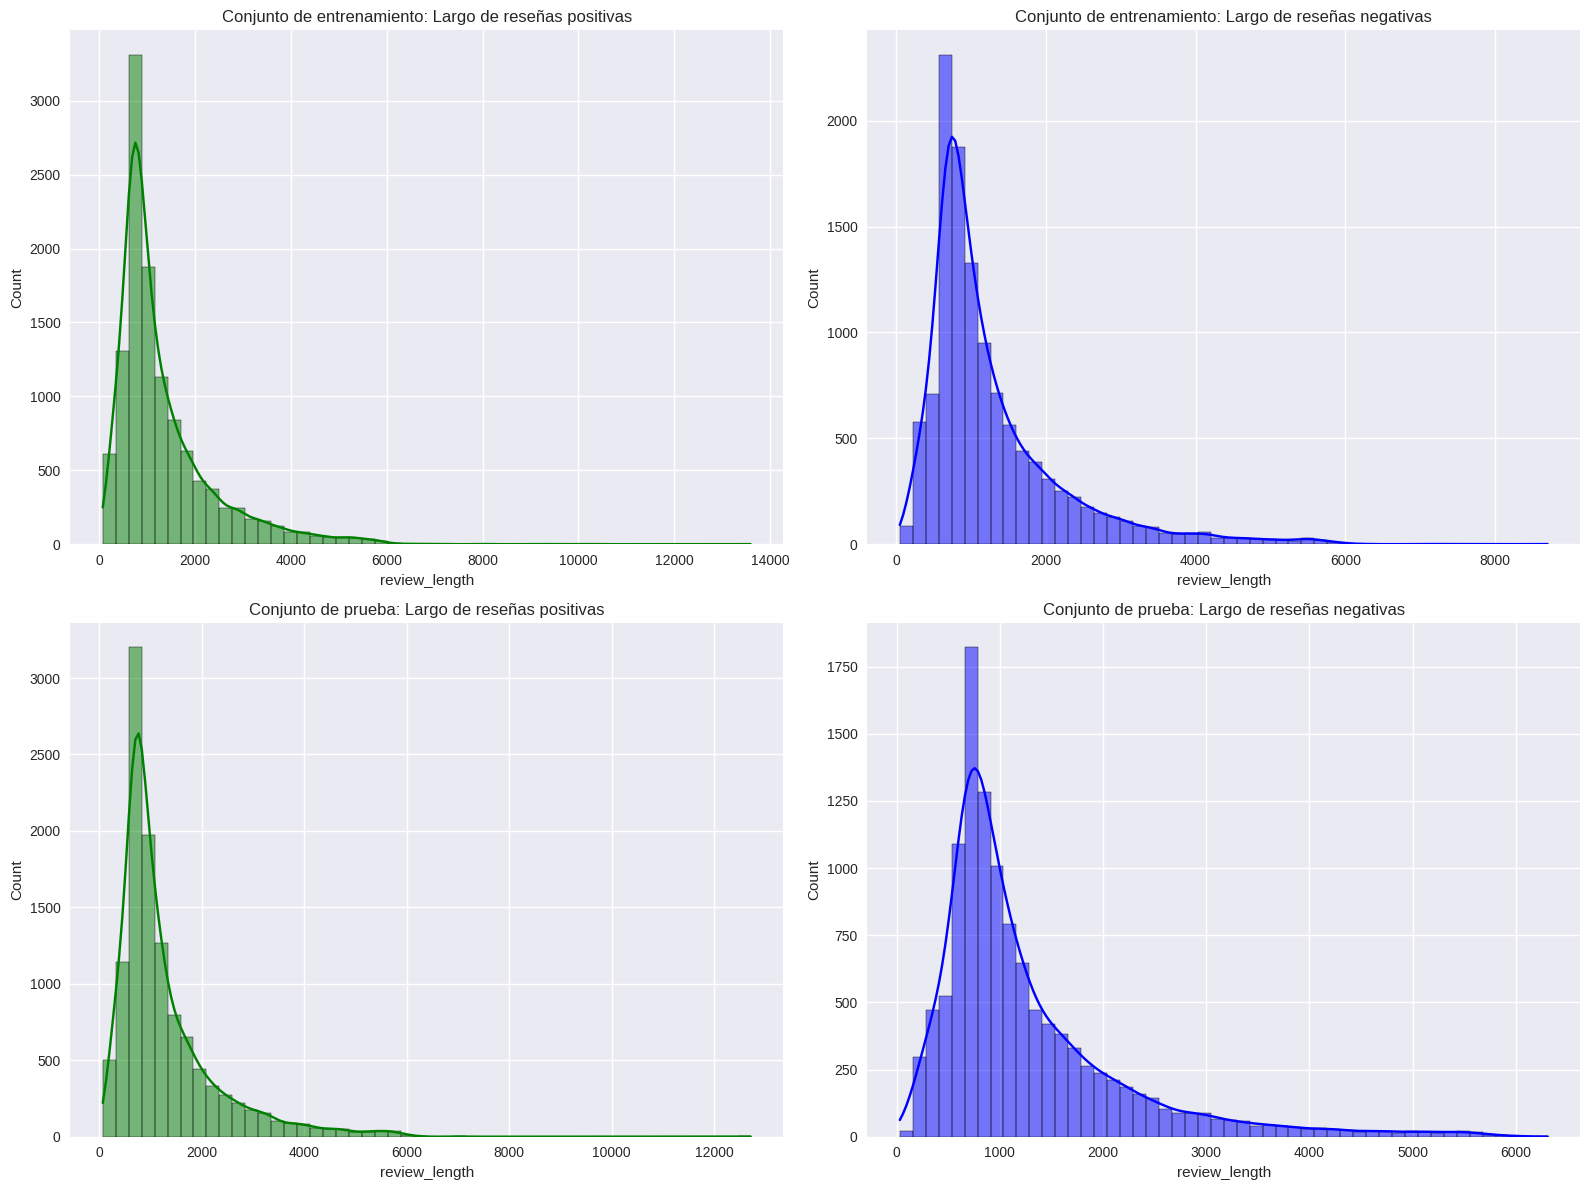

In [17]:
# Calculamos el largo de las reseñas
df_reviews['review_length'] = df_reviews['review'].apply(len)

# Filtramos las reseñas para el conjunto de entrenamiento y prueba
train_reviews = df_reviews[df_reviews['ds_part'] == 'train']
test_reviews = df_reviews[df_reviews['ds_part'] == 'test']

# Creamos los gráficos
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Conjunto de entrenamiento - Positivas y Negativas
sns.histplot(train_reviews[train_reviews['pos'] == 1]['review_length'], bins=50, kde=True, ax=axs[0, 0], color='green')
axs[0, 0].set_title('Conjunto de entrenamiento: Largo de reseñas positivas')
sns.histplot(train_reviews[train_reviews['pos'] == 0]['review_length'], bins=50, kde=True, ax=axs[0, 1], color='blue')
axs[0, 1].set_title('Conjunto de entrenamiento: Largo de reseñas negativas')

# Conjunto de prueba - Positivas y Negativas
sns.histplot(test_reviews[test_reviews['pos'] == 1]['review_length'], bins=50, kde=True, ax=axs[1, 0], color='green')
axs[1, 0].set_title('Conjunto de prueba: Largo de reseñas positivas')
sns.histplot(test_reviews[test_reviews['pos'] == 0]['review_length'], bins=50, kde=True, ax=axs[1, 1], color='blue')
axs[1, 1].set_title('Conjunto de prueba: Largo de reseñas negativas')

plt.tight_layout()
plt.show()



Tanto las reseñas positivas como las negativas tienden a tener una distribución sesgada a la derecha. Esto significa que la mayoría de las reseñas son relativamente cortas, y hay pocas reseñas que son muy largas.

Esta tendencia se observa de manera consistente en los conjuntos de entrenamiento y de prueba, lo cual es positivo ya que sugiere que los datos están distribuidos de manera similar en ambos conjuntos.

Reseñas Positivas: Las reseñas positivas tienden a ser un poco más largas en comparación con las negativas. Esto podría indicar que los usuarios tienden a escribir más cuando tienen una experiencia positiva y desean compartir más detalles.

Reseñas Negativas: Las reseñas negativas, aunque también siguen una distribución sesgada a la derecha, parecen tener una cola más corta en comparación con las positivas. Esto sugiere que las reseñas negativas son generalmente más concisas.

Las distribuciones en ambos conjuntos son bastante similares, lo cual es un buen indicativo de que no hay un sesgo significativo en la partición de los datos. Esto es crucial para asegurar que el modelo generalice bien a datos no vistos.


## Rutina de evaluación

Se define una rutina de evaluación que podremos utilizar para los modelos que utilizaremos en el proyecto.

In [34]:


def evaluate_model_1(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return


## Preprocesamiento de datos para el modelado

A continuación vamos a realizar el preprocesamiento del texto y la vectorización.

In [19]:
%%time

# Descargamos los stopwords de NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Cargamos el modelo de Spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Definimos las funciones de preprocesamiento:
# clear_text: Limpia el texto eliminando caracteres no alfabéticos y convirtiendo a minúsculas.
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    return clean_text.lower()

# lemmatize: Lemmatiza el texto utilizando Spacy.
def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

# Aplicamos preprocesamiento a las reseñas
df_reviews['cleaned_review'] = df_reviews['review'].progress_apply(clear_text)
df_reviews['lemmatized_review'] = df_reviews['cleaned_review'].progress_apply(lemmatize)

# Separamos los conjuntos de entrenamiento y prueba
train_reviews = df_reviews[df_reviews['ds_part'] == 'train']
test_reviews = df_reviews[df_reviews['ds_part'] == 'test']

# Vectorización con TF-IDF
# Utilizamos TfidfVectorizer para transformar las reseñas lematizadas en vectores TF-IDF.
tfidf = TfidfVectorizer(stop_words="english", lowercase=True)
train_tfidf = tfidf.fit_transform(train_reviews['lemmatized_review'])
test_tfidf = tfidf.transform(test_reviews['lemmatized_review'])

print("Dimensiones del conjunto de entrenamiento TF-IDF:", train_tfidf.shape)
print("Dimensiones del conjunto de prueba TF-IDF:", test_tfidf.shape)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/47331 [00:00<?, ?it/s]

  0%|          | 0/47331 [00:00<?, ?it/s]

Dimensiones del conjunto de entrenamiento TF-IDF: (23796, 58977)
Dimensiones del conjunto de prueba TF-IDF: (23535, 58977)
CPU times: user 17min 52s, sys: 7.59 s, total: 17min 59s
Wall time: 18min 32s


In [20]:
# Definimos las características y etiquetas
train_features = train_tfidf
test_features = test_tfidf
train_target = train_reviews['pos']
test_target = test_reviews['pos']

## Entrenamiento y prueba de Modelos

Ahora podemos continuar con el entrenamiento y evaluación de los modelos. Vamos a trabajr con los modelos de Regresión Logística, Bosque Aleatorio y LightGBM. 

### Modelo Regresión Logística

Evaluación del modelo de Regresión Logística (model_lr):
          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95
CPU times: user 2.29 s, sys: 4.03 s, total: 6.32 s
Wall time: 6.3 s


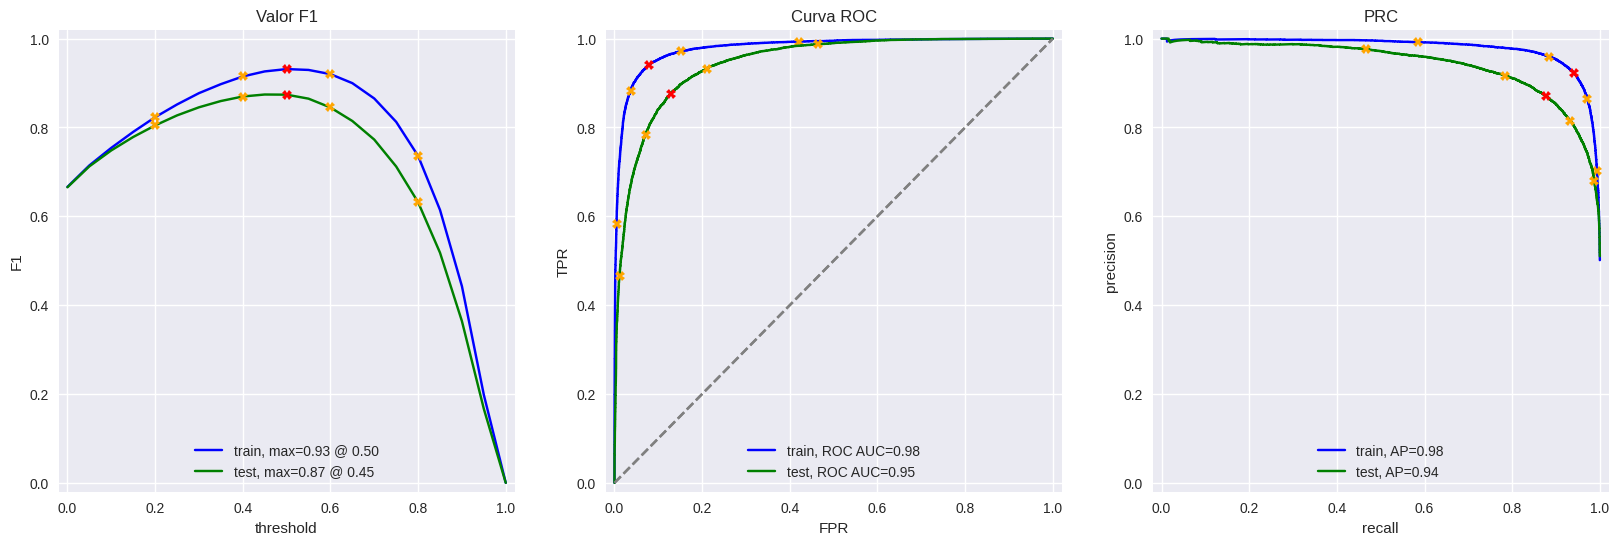

In [21]:
%%time
# Entrenar y evaluar el modelo de Regresión Logística (model_lr)
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(train_features, train_target)
print("Evaluación del modelo de Regresión Logística (model_lr):")
evaluate_model_1(model_lr, train_features, train_target, test_features, test_target)



El modelo de regresión logística entrega un alto rendimiento en términos de exactitud, valor F1, APS y ROC AUC, tanto en el conjunto de entrenamiento como en el conjunto de prueba. Esto indica que el modelo es capaz de discriminar eficazmente entre reseñas positivas y negativas.

El modelo cumple con el objetivo establecido en el enunciado, alcanzando un valor F1 de al menos 0.85 en el conjunto de prueba.

### Modelo Bosque Aleatorio

Primero realizamos la ejecución de un Modelo Simple de Bosque Aleatorio.

Evaluación del modelo de Bosque Aleatorio (model_rf):
          train  test
Accuracy    1.0  0.84
F1          1.0  0.84
APS         1.0  0.91
ROC AUC     1.0  0.92
CPU times: user 59.4 s, sys: 74 ms, total: 59.5 s
Wall time: 59.6 s


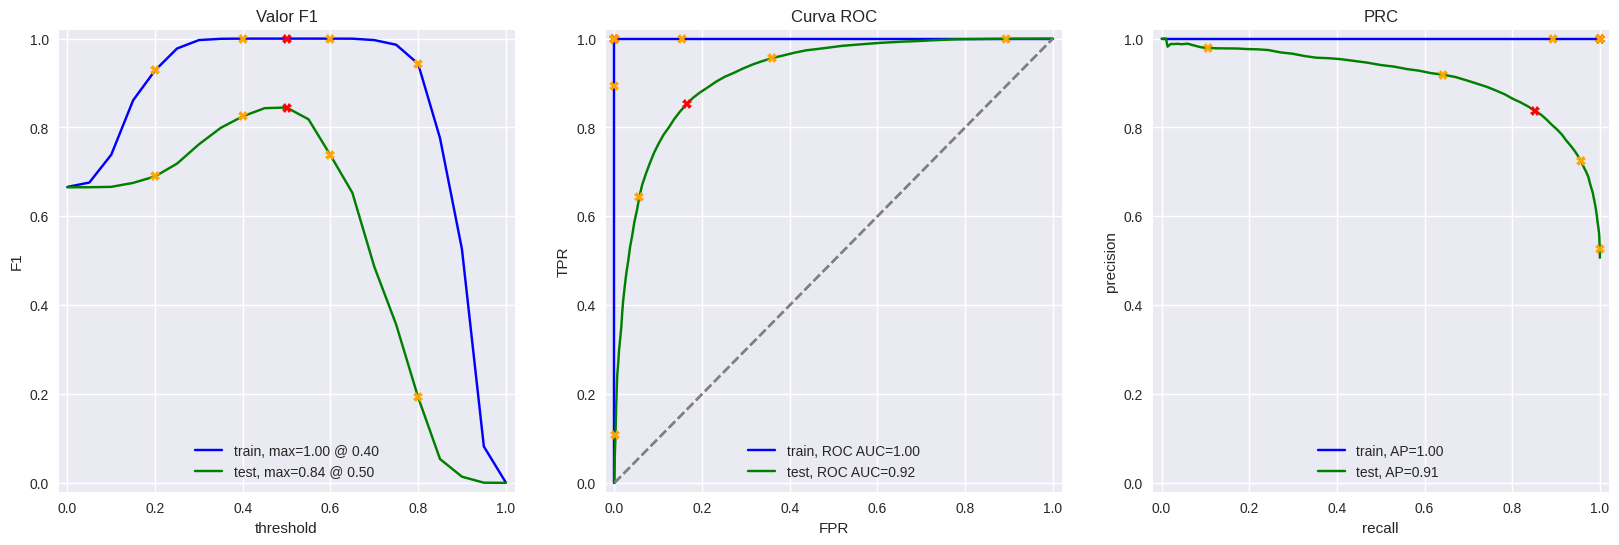

In [22]:
%%time
# Entrenar y evaluar el modelo de Bosque Aleatorio (model_rf)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(train_features, train_target)
print("Evaluación del modelo de Bosque Aleatorio (model_rf):")
evaluate_model_1(model_rf, train_features, train_target, test_features, test_target)

Como tenemos un resultado de un F1 de 0.84, vamos a realizar un bucle for para optimizar los hiperparámetros del modelo.

In [23]:
%%time
# Inicializar el mejor puntaje y los mejores hiperparámetros
max_score_rf = 0
best_params_rf = {'n_estimators': None, 'max_depth': None}

# Bucle para ajustar los hiperparámetros
for n_estimators in [50, 100, 200]:
    for max_depth in [None, 10, 20]:
        model_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model_rf.fit(train_features, train_target)
        y_pred_rf = model_rf.predict(test_features)
        score_rf = f1_score(test_target, y_pred_rf)

        if score_rf > max_score_rf:
            max_score_rf = score_rf
            best_params_rf['n_estimators'] = n_estimators
            best_params_rf['max_depth'] = max_depth
            print(f"""
            N estimators: {n_estimators}
            Max depth: {max_depth}
            F1 Score: {round(score_rf, 2)}
            """)

print(f"Mejores hiperparámetros para Bosque Aleatorio: {best_params_rf}")


            N estimators: 50
            Max depth: None
            F1 Score: 0.83
            

            N estimators: 100
            Max depth: None
            F1 Score: 0.84
            

            N estimators: 200
            Max depth: None
            F1 Score: 0.85
            
Mejores hiperparámetros para Bosque Aleatorio: {'n_estimators': 200, 'max_depth': None}
CPU times: user 3min 45s, sys: 145 ms, total: 3min 45s
Wall time: 3min 45s


Evaluación del modelo de Bosque Aleatorio con los mejores hiperparámetros:
          train  test
Accuracy    1.0  0.85
F1          1.0  0.85
APS         1.0  0.92
ROC AUC     1.0  0.93
CPU times: user 1min 59s, sys: 109 ms, total: 1min 59s
Wall time: 1min 59s


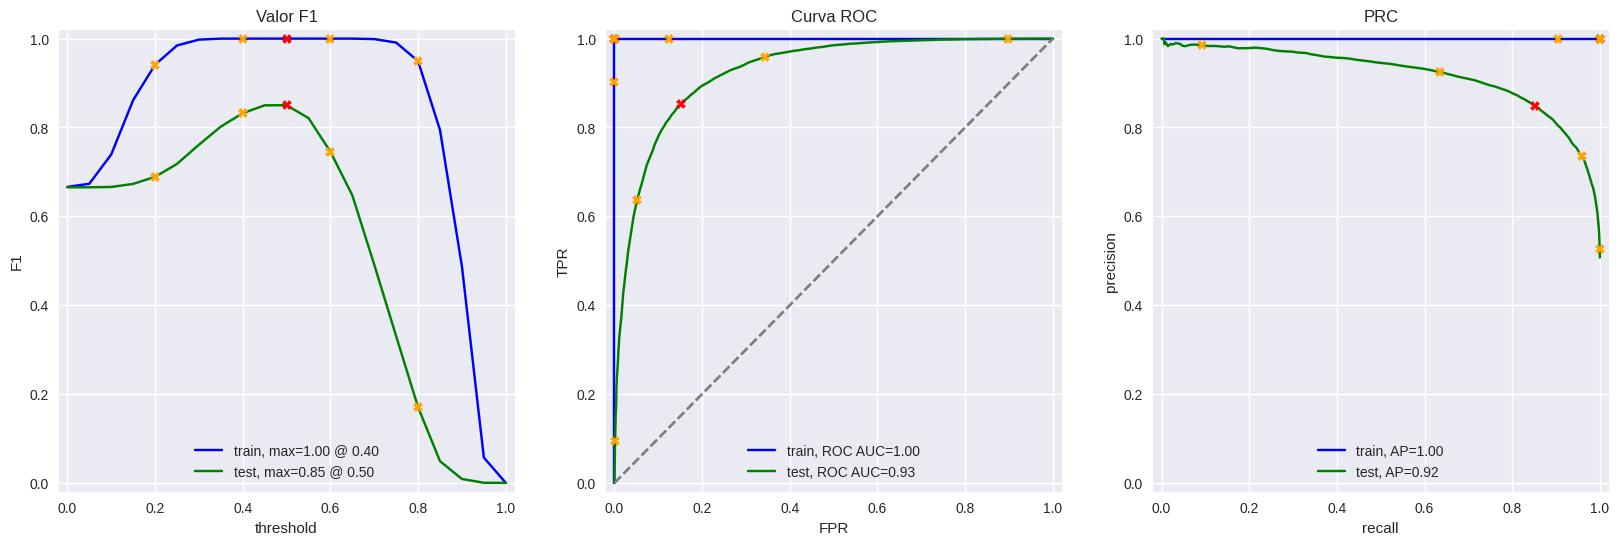

In [24]:
%%time
# Ajustar el modelo de Bosque Aleatorio con los mejores hiperparámetros
best_model_rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
best_model_rf.fit(train_features, train_target)

print("Evaluación del modelo de Bosque Aleatorio con los mejores hiperparámetros:")
evaluate_model_1(best_model_rf, train_features, train_target, test_features, test_target)

El modelo de Bosque Aleatorio, ajustado con los mejores hiperparámetros, muestra un excelente rendimiento en el conjunto de entrenamiento, pero presenta indicios de sobreajuste cuando se evalúa en el conjunto de prueba. Sin embargo cumple con el requisito de alcanzar un valor F1 de al menos 0.85.

### Modelo LightGBM

Primero realizamos la ejecución de un Modelo Simple de LightGBM.

Evaluación del modelo de LightGBM (model_lgb):
          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93
CPU times: user 50.7 s, sys: 374 ms, total: 51.1 s
Wall time: 51.2 s


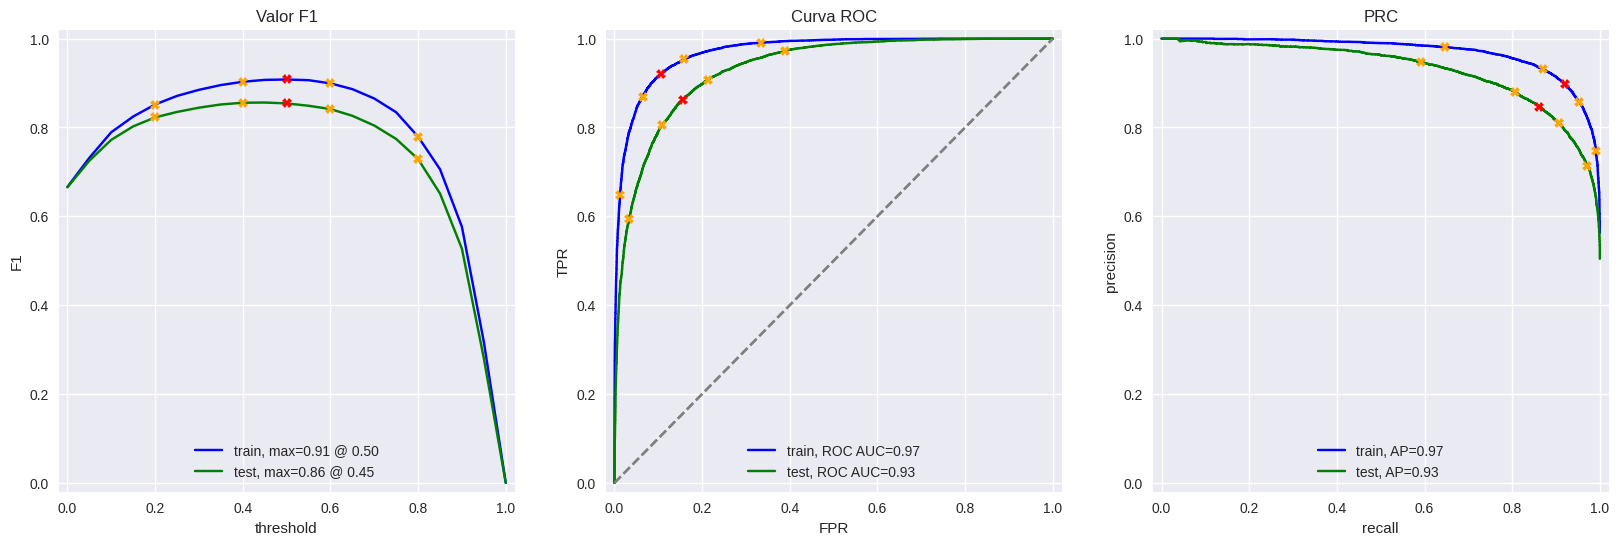

In [25]:
%%time
# Entrenar y evaluar el modelo de LightGBM (model_lgb)
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(train_features, train_target)
print("Evaluación del modelo de LightGBM (model_lgb):")
evaluate_model_1(model_lgb, train_features, train_target, test_features, test_target)

De igual forma, ahora procederemos a utilizar un bucle for para optimizar los hiperparámetros del modelo LightGBM.

In [26]:
%%time
# Inicializar el mejor puntaje y los mejores hiperparámetros
max_score_lgb = 0
best_params_lgb = {'num_leaves': None, 'n_estimators': None}

# Bucle para ajustar los hiperparámetros
for num_leaves in [31, 50, 100]:
    for n_estimators in [50, 100, 200]:
        model_lgb = lgb.LGBMClassifier(num_leaves=num_leaves, n_estimators=n_estimators, random_state=42)
        model_lgb.fit(train_features, train_target)
        y_pred_lgb = model_lgb.predict(test_features)
        score_lgb = f1_score(test_target, y_pred_lgb)

        if score_lgb > max_score_lgb:
            max_score_lgb = score_lgb
            best_params_lgb['num_leaves'] = num_leaves
            best_params_lgb['n_estimators'] = n_estimators
            print(f"""
            Num leaves: {num_leaves}
            N estimators: {n_estimators}
            F1 Score: {round(score_lgb, 2)}
            """)

print(f"Mejores hiperparámetros para LightGBM: {best_params_lgb}")



            Num leaves: 31
            N estimators: 50
            F1 Score: 0.84
            

            Num leaves: 31
            N estimators: 100
            F1 Score: 0.85
            

            Num leaves: 31
            N estimators: 200
            F1 Score: 0.86
            

            Num leaves: 50
            N estimators: 200
            F1 Score: 0.87
            

            Num leaves: 100
            N estimators: 200
            F1 Score: 0.87
            
Mejores hiperparámetros para LightGBM: {'num_leaves': 100, 'n_estimators': 200}
CPU times: user 12min 21s, sys: 5.09 s, total: 12min 26s
Wall time: 12min 28s


Evaluación del modelo de LightGBM con los mejores hiperparámetros:
          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94
CPU times: user 3min 19s, sys: 1.41 s, total: 3min 20s
Wall time: 3min 21s


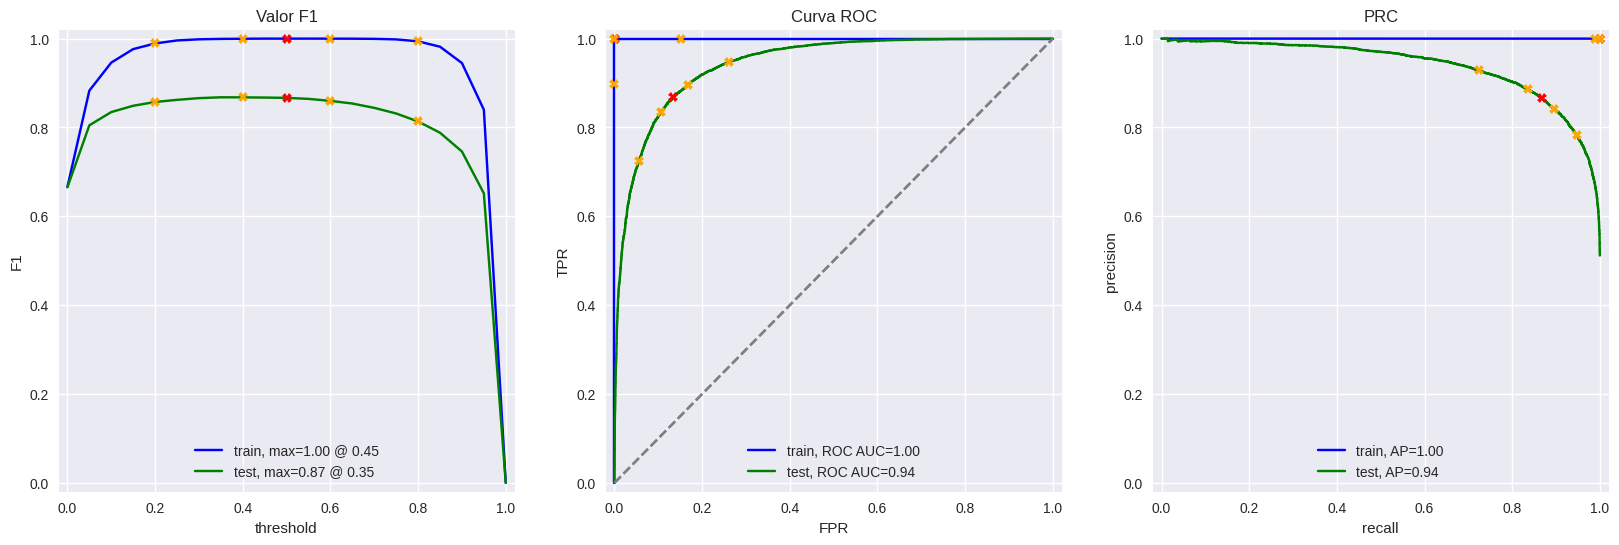

In [27]:
%%time
# Ajustar el modelo de LightGBM con los mejores hiperparámetros
best_model_lgb = lgb.LGBMClassifier(num_leaves=100, n_estimators=200, random_state=42)
best_model_lgb.fit(train_features, train_target)

print("Evaluación del modelo de LightGBM con los mejores hiperparámetros:")
evaluate_model_1(best_model_lgb, train_features, train_target, test_features, test_target)


El modelo LightGBM ha mostrado un excelente rendimiento en el conjunto de entrenamiento, con métricas perfectas (Exactitud, F1, APS, ROC AUC todas igual a 1.0), lo que indica una capacidad excepcional para clasificar las reseñas en el conjunto de entrenamiento.

Sinembargo, al igual que el modelo de Bosque Aleatorio, la disparidad entre las métricas del conjunto de entrenamiento y las del conjunto de prueba sugiere que el modelo puede estar sobreajustado. Esto es evidente en la perfecta clasificación en el conjunto de entrenamiento frente a una disminución en las métricas en el conjunto de prueba.

El modelo cumple con el objetivo establecido en el enunciado, alcanzando un valor F1 de al menos 0.85 en el conjunto de prueba. 

## Pruebas Manuales

Ahora vamos a escribir algunas reseñas y clasifícarlas con todos los modelos.

### Clasificación reseñas por los modelos

In [30]:
# Reseñas de ejemplo
sample_reviews = [
    "I absolutely loved this movie! The plot was gripping and the characters were very well developed.",
    "The film was terrible. The storyline was boring and the acting was mediocre.",
    "It was an okay movie. Some parts were interesting but it could have been better.",
    "Amazing film! A must-watch for everyone.",
    "I did not enjoy this movie. It was too long and the plot was predictable."
]

# Limpiar y lematizar las reseñas de ejemplo
sample_reviews_clean = [clear_text(review) for review in sample_reviews]
sample_reviews_lemmatized = [lemmatize(review) for review in sample_reviews_clean]

# Transformar las reseñas usando el vectorizador ajustado (sin volver a ajustarlo)
sample_reviews_tfidf = tfidf.transform(sample_reviews_clean)

# Definir los modelos
models = {
    "Regresión Logística": model_lr,
    "Bosque Aleatorio": best_model_rf,
    "LightGBM": best_model_lgb
}

# Función para imprimir resultados de clasificación
def print_classification_results(model, model_name, review_tfidf):
    prediction = model.predict(review_tfidf)[0]
    prediction_label = 'Positive' if prediction == 1 else 'Negative'
    print(f"Model: {model_name}, prediction: {prediction_label}")

# Clasificar las reseñas de ejemplo usando los modelos
for i, review in enumerate(sample_reviews):
    obs_data = sample_reviews_tfidf[i]
    print(f"Text: {review}")
    for model_name, model in models.items():
        print_classification_results(model, model_name, obs_data)
    print("="*80)


Text: I absolutely loved this movie! The plot was gripping and the characters were very well developed.
Model: Regresión Logística, prediction: Negative
Model: Bosque Aleatorio, prediction: Positive
Model: LightGBM, prediction: Negative
Text: The film was terrible. The storyline was boring and the acting was mediocre.
Model: Regresión Logística, prediction: Negative
Model: Bosque Aleatorio, prediction: Negative
Model: LightGBM, prediction: Negative
Text: It was an okay movie. Some parts were interesting but it could have been better.
Model: Regresión Logística, prediction: Negative
Model: Bosque Aleatorio, prediction: Positive
Model: LightGBM, prediction: Negative
Text: Amazing film! A must-watch for everyone.
Model: Regresión Logística, prediction: Positive
Model: Bosque Aleatorio, prediction: Positive
Model: LightGBM, prediction: Positive
Text: I did not enjoy this movie. It was too long and the plot was predictable.
Model: Regresión Logística, prediction: Negative
Model: Bosque Alea

### Análisis de los resultados de las pruebas manuales

Prueba 1:
Texto: "I absolutely loved this movie! The plot was gripping and the characters were very well developed."
Regresión Logística: Predicción: Negativa
Bosque Aleatorio: Predicción: Positiva
LightGBM: Predicción: Negativa
Comentario: Aquí vemos una discrepancia entre el modelo de Bosque Aleatorio y los otros dos modelos. La frase tiene un tono claramente positivo, por lo que el Bosque Aleatorio parece haber capturado mejor el sentimiento positivo, mientras que los otros dos modelos lo interpretaron incorrectamente como negativo.

Prueba 2:
Texto: "The film was terrible. The storyline was boring and the acting was mediocre."
Regresión Logística: Predicción: Negativa
Bosque Aleatorio: Predicción: Negativa
LightGBM: Predicción: Negativa
Comentario: En este caso, todos los modelos coincidieron en clasificar la reseña como negativa, lo cual es correcto ya que la reseña tiene un tono claramente negativo.

Prueba 3:
Texto: "It was an okay movie. Some parts were interesting but it could have been better."
Regresión Logística: Predicción: Negativa
Bosque Aleatorio: Predicción: Positiva
LightGBM: Predicción: Negativa
Comentario: Aquí nuevamente vemos una discrepancia, donde el Bosque Aleatorio clasificó la reseña como positiva, mientras que los otros dos modelos la clasificaron como negativa. La reseña es más neutral, pero tiende hacia el lado negativo debido a la frase "could have been better".

Prueba 4:
Texto: "Amazing film! A must-watch for everyone."
Regresión Logística: Predicción: Positiva
Bosque Aleatorio: Predicción: Positiva
LightGBM: Predicción: Positiva
Comentario: Todos los modelos coincidieron en clasificar la reseña como positiva, lo cual es correcto ya que la reseña tiene un tono claramente positivo.

Prueba 5:
Texto: "I did not enjoy this movie. It was too long and the plot was predictable."
Regresión Logística: Predicción: Negativa
Bosque Aleatorio: Predicción: Positiva
LightGBM: Predicción: Negativa
Comentario: En este caso, el modelo de Bosque Aleatorio nuevamente se desvió de los otros dos modelos al clasificar la reseña negativa como positiva.


### Comparación entre los resultados de las pruebas manuales y las pruebas de evaluación anteriores.

- Consistencia:

El modelo de Regresión Logística y el modelo LightGBM mostraron una mayor consistencia en la clasificación de las reseñas de prueba manual, coincidiendo en 4 de las 5 reseñas.
El modelo de Bosque Aleatorio, aunque tuvo buen rendimiento en las métricas generales, mostró inconsistencias en la clasificación manual, especialmente en las reseñas donde el sentimiento no es tan claro.

- Discrepancias en el modelo de Bosque Aleatorio:

El modelo de Bosque Aleatorio tiende a clasificar algunas reseñas ambiguas o neutrales como positivas, lo que puede indicar una tendencia a sobrevalorar las palabras positivas en contextos mixtos o neutros.
Este comportamiento puede ser debido a la naturaleza del modelo de Bosque Aleatorio, que puede ser más sensible a ciertas palabras clave que aparecen en las reseñas positivas en el conjunto de entrenamiento.

- Generalización y sobreajuste:

Aunque el modelo de Bosque Aleatorio mostró excelentes métricas de entrenamiento (Exactitud, F1, APS, ROC AUC todas igual a 1.0), su comportamiento en las pruebas manuales sugiere que puede estar sobreajustado, capturando patrones específicos del conjunto de entrenamiento que no generalizan bien a nuevas reseñas.

El modelo LightGBM, aunque también muestra altas métricas en el conjunto de entrenamiento, parece generalizar mejor en las pruebas manuales, lo que sugiere un mejor equilibrio entre ajuste y generalización.

## Conclusiones Generales

- Regresión Logística: Aunque tuvo menor rendimiento en algunas métricas comparado con los otros dos modelos, mostró una buena capacidad de generalización y consistencia en las pruebas manuales.

- Bosque Aleatorio: Aunque mostró excelentes métricas de rendimiento, su desempeño en las pruebas manuales reveló posibles problemas de sobreajuste y sensibilidad a palabras específicas.

- LightGBM: Mostró un buen equilibrio entre rendimiento y generalización, con una alta consistencia en las pruebas manuales y métricas robustas en las evaluaciones.

Estas observaciones sugieren que, aunque las métricas de rendimiento son importantes, también es crucial evaluar cómo los modelos se comportan con ejemplos reales y manuales para obtener una visión completa de su capacidad de generalización y precisión.